<a href="https://colab.research.google.com/github/firmansyahr/Customer-Segmentation-Loyalty-Analytics/blob/main/Notebook/1_KMEANS_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

df = pd.read_excel(next(iter(uploaded)))
print("Data Loaded:")
print(df.head())

Saving Transaksi Regional 3, 4, dan 5 2024.xlsx to Transaksi Regional 3, 4, dan 5 2024.xlsx
Data Loaded:
         Tanggal    ID Toko                  Nama Toko         Cluster  \
0  Februari 2024  100121021  UD Widiastuti Simanjuntak  SUPER PLATINUM   
1  Februari 2024  100164612              UD Tampubolon            GOLD   
2  Februari 2024  100165231  UD Widiastuti Simanjuntak        PLATINUM   
3  Februari 2024  100051536              UD Tampubolon            GOLD   
4  Februari 2024  100023720         UD Ramadan Nababan        PLATINUM   

   Regional Area Toko          Kabupaten Toko Total Ton Total Poin  \
0         3   AREA 33  KOTA TANGERANG SELATAN    164.05        164   
1         3   AREA 33     KABUPATEN TANGERANG      79.4         79   
2         3   AREA 33     KABUPATEN TANGERANG       256        256   
3         3   AREA 33          KOTA TANGERANG      88.4         88   
4         3   AREA 33     KABUPATEN TANGERANG     240.3        240   

  Total Reward  
0      10253

In [ ]:
df['Total Ton'] = pd.to_numeric(df['Total Ton'].astype(str).str.replace(',', '.'), errors='coerce')
df['Total Poin'] = pd.to_numeric(df['Total Poin'].astype(str).str.replace(',', '.'), errors='coerce')
df['Total Reward'] = df['Total Reward'].astype(str).str.replace('Rp', '', regex=False).str.replace('.', '', regex=False).str.strip()
df['Total Reward'] = pd.to_numeric(df['Total Reward'], errors='coerce')

df.dropna(subset=['Total Ton', 'Total Poin', 'Total Reward'], inplace=True)

In [ ]:
agg = df.groupby('ID Toko').agg({
    'Total Ton': 'sum',
    'Total Poin': 'sum',
    'Total Reward': 'sum',
    'Regional': 'first',
    'Cluster': 'first'
}).reset_index()


In [ ]:
agg['Poin_Extra'] = agg['Total Poin'] - agg['Total Ton']
agg['Reward_per_Poin'] = agg['Total Reward'] / agg['Total Poin']

agg.replace([np.inf, -np.inf], np.nan, inplace=True)
agg.dropna(subset=['Poin_Extra', 'Reward_per_Poin'], inplace=True)

print("\nContoh ringkasan per toko:")
print(agg.head())


Contoh ringkasan per toko:
     ID Toko  Total Ton  Total Poin  Total Reward  Regional         Cluster  \
0  100000091     849.00      881.00     4405000.0         5            Gold   
1  100000106    1472.26     1877.16     9383300.0         5          Bronze   
2  100000108    1850.00     2108.00    10540000.0         5          Bronze   
3  100000109    1906.72     2104.72    10523600.0         5          Silver   
4  100000110    1547.88     1843.88     9219400.0         5  Super Platinum   

   Poin_Extra  Reward_per_Poin  
0        32.0      5000.000000  
1       404.9      4998.668201  
2       258.0      5000.000000  
3       198.0      5000.000000  
4       296.0      5000.000000  


In [ ]:
agg['Regional'] = agg['Regional'].astype(str)


In [ ]:
encoder = OneHotEncoder(
    sparse_output=False,
    drop='first',
    categories=[['3', '4', '5']]
)
region_encoded = encoder.fit_transform(agg[['Regional']])
region_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['Regional']))

print("\nDummy Regional yang dibuat:")
print(region_df.head())


Dummy Regional yang dibuat:
   Regional_4  Regional_5
0         0.0         1.0
1         0.0         1.0
2         0.0         1.0
3         0.0         1.0
4         0.0         1.0


In [ ]:
agg_encoded = pd.concat([agg.reset_index(drop=True), region_df.reset_index(drop=True)], axis=1)


In [ ]:
features = ['Total Ton', 'Poin_Extra'] + list(region_df.columns)
print("\nFitur yang digunakan untuk clustering:")
print(features)

X = agg_encoded[features]


Fitur yang digunakan untuk clustering:
['Total Ton', 'Poin_Extra', 'Regional_4', 'Regional_5']


In [ ]:
scaled_df = pd.DataFrame(
    X_scaled,
    columns=['Feature1', 'Feature2'] if X_scaled.shape[1] == 2 else [f'PC{i+1}' for i in range(X_scaled.shape[1])]
)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


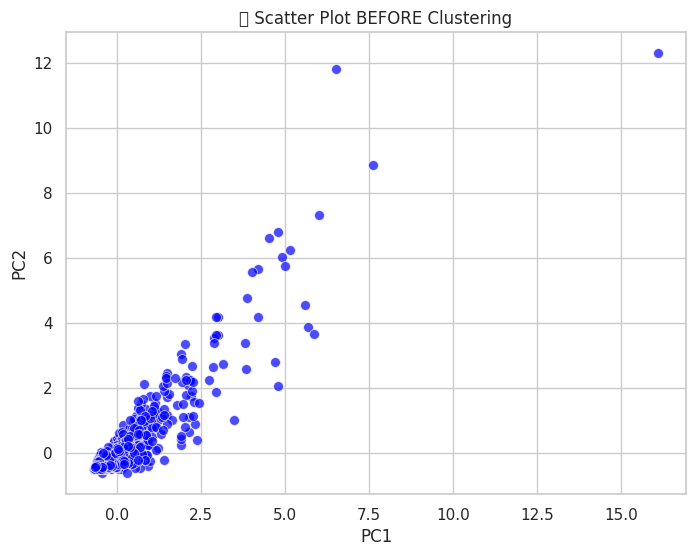

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=scaled_df,
    x=scaled_df.columns[0],
    y=scaled_df.columns[1],
    color='blue',
    s=50,
    alpha=0.7
)
plt.title('📌 Scatter Plot BEFORE Clustering')
plt.xlabel(scaled_df.columns[0])
plt.ylabel(scaled_df.columns[1])
plt.grid(True)
plt.show()

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
agg_encoded['Cluster_Baru'] = kmeans.fit_predict(X_scaled)

In [ ]:
sil_score = silhouette_score(X_scaled, agg_encoded['Cluster_Baru'])
print(f"\nSilhouette Score (K=5): {sil_score:.4f}")


Silhouette Score (K=5): 0.7344


In [ ]:
summary = agg_encoded.groupby('Cluster_Baru')[features].mean().round(2)
print("\nProfil Cluster Baru (Level Toko):")
print(summary)


Profil Cluster Baru (Level Toko):
              Total Ton  Poin_Extra  Regional_4  Regional_5
Cluster_Baru                                               
0               1033.82      683.17        1.00        0.00
1               1877.04      683.94        0.00        1.00
2              20258.31    18144.61        0.06        0.94
3               1356.68      826.36        0.00        0.00
4               7663.95     5861.25        0.03        0.92


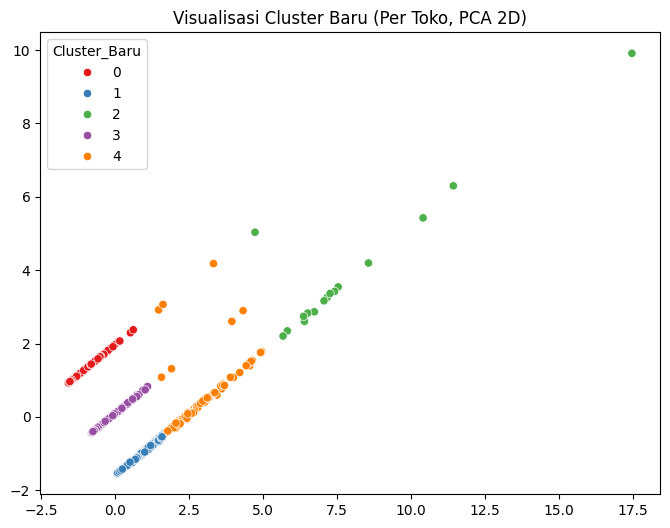

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=agg_encoded['Cluster_Baru'], palette='Set1')
plt.title('Visualisasi Cluster Baru (Per Toko, PCA 2D)')
plt.show()

In [ ]:
# Clustering hasil
agg_encoded['Cluster_Baru'] = kmeans.fit_predict(X_scaled)

# Cek Silhouette
sil_score = silhouette_score(X_scaled, agg_encoded['Cluster_Baru'])
print(f"\nSilhouette Score (K=5): {sil_score:.4f}")




Silhouette Score (K=5): 0.7344


K=2 => Silhouette Score: 0.5206
K=3 => Silhouette Score: 0.5465
K=4 => Silhouette Score: 0.6993
K=5 => Silhouette Score: 0.7344
K=6 => Silhouette Score: 0.7350
K=7 => Silhouette Score: 0.6837
K=8 => Silhouette Score: 0.6840
K=9 => Silhouette Score: 0.6511
K=10 => Silhouette Score: 0.6093


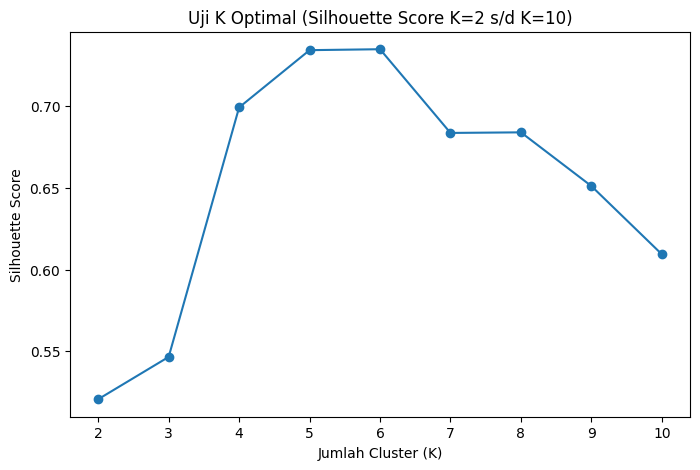

In [ ]:
range_k = range(2, 11)
scores = []

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append(score)
    print(f"K={k} => Silhouette Score: {score:.4f}")

# Plot hasil
plt.figure(figsize=(8,5))
plt.plot(range_k, scores, marker='o')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('Silhouette Score')
plt.title('Uji K Optimal (Silhouette Score K=2 s/d K=10)')
plt.xticks(range_k)
plt.show()

In [ ]:
print(f"Ukuran data: {X_scaled.shape}")

Ukuran data: (1255, 4)


In [ ]:
print("X_scaled shape:", X_scaled.shape)
print(agg_encoded['Cluster'].unique())

X_scaled shape: (1255, 4)
['Gold' 'Bronze' 'Silver' 'Super Platinum' 'Platinum']


In [ ]:
linked = linkage(X_scaled, method='ward')

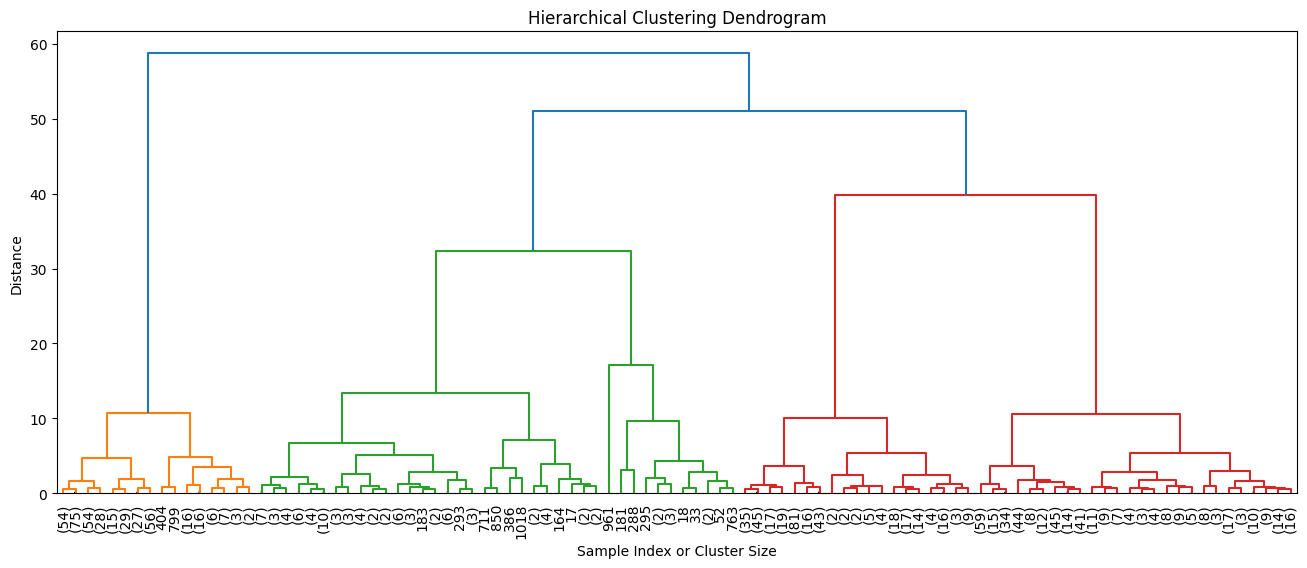

In [ ]:
plt.figure(figsize=(16, 6))
dendrogram(
    linked,
    truncate_mode='lastp',  # tunjukkan cluster level tinggi saja
    p=100,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.show()

In [ ]:
sns.set(style="whitegrid")

In [ ]:
print(agg_encoded.head())

     ID Toko  Total Ton  Total Poin  Total Reward Regional         Cluster  \
0  100000091     849.00      881.00     4405000.0        5            Gold   
1  100000106    1472.26     1877.16     9383300.0        5          Bronze   
2  100000108    1850.00     2108.00    10540000.0        5          Bronze   
3  100000109    1906.72     2104.72    10523600.0        5          Silver   
4  100000110    1547.88     1843.88     9219400.0        5  Super Platinum   

   Poin_Extra  Reward_per_Poin  Regional_4  Regional_5  Cluster_Baru  
0        32.0      5000.000000         0.0         1.0             1  
1       404.9      4998.668201         0.0         1.0             1  
2       258.0      5000.000000         0.0         1.0             1  
3       198.0      5000.000000         0.0         1.0             1  
4       296.0      5000.000000         0.0         1.0             1  


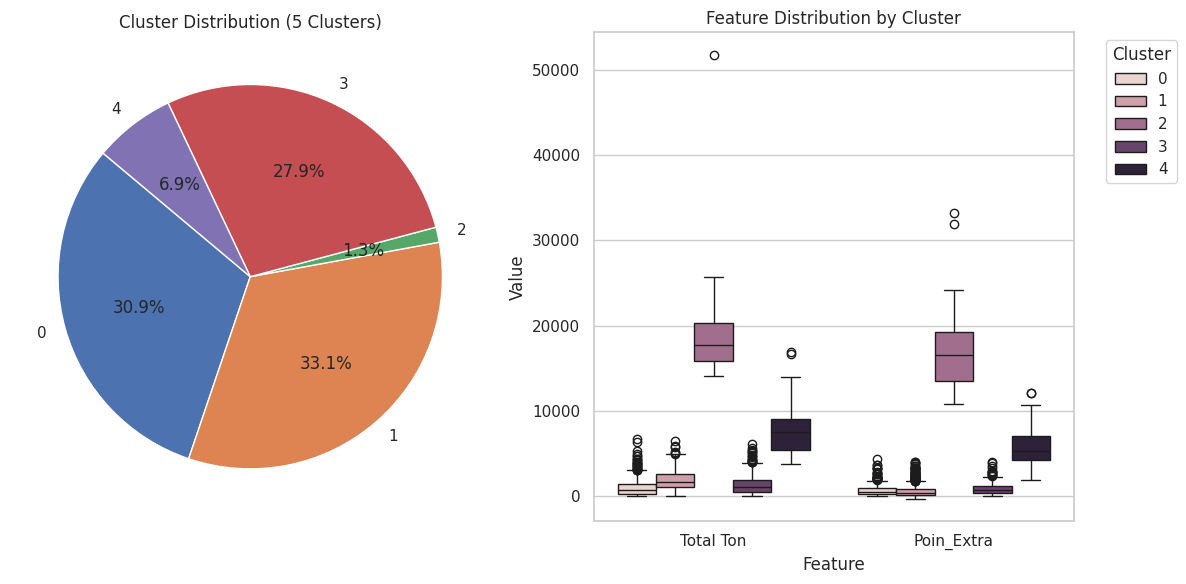

In [ ]:
plt.figure(figsize=(12, 6))

# Subplot 1: PIE
plt.subplot(1, 2, 1)
cluster_counts = agg_encoded['Cluster_Baru'].value_counts().sort_index()
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Cluster Distribution ({len(cluster_counts)} Clusters)')

# ==========================================
# 📊 2) BOXPLOT — Fitur per Cluster

# Subplot 2: BOXPLOT
plt.subplot(1, 2, 2)
# Pilih fitur numeric yang mau dibandingkan
features_to_plot = ['Total Ton', 'Poin_Extra']

# Melt ke long-form: kolom = ['Cluster_Baru', 'Feature', 'Value']
df_melt = agg_encoded.melt(
    id_vars=['Cluster_Baru'],
    value_vars=features_to_plot,
    var_name='Feature',
    value_name='Value'
)

sns.boxplot(data=df_melt, x='Feature', y='Value', hue='Cluster_Baru')
plt.title('Feature Distribution by Cluster')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
best_score = -1
best_k = None
scores = []

# Uji K dari 2 sampai 10
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append((k, score))
    print(f"K={k} → Silhouette Score: {score:.4f}")

    if score > best_score:
        best_score = score
        best_k = k

print(f"\n✅ Best K: {best_k} → Silhouette Score: {best_score:.4f}")

K=2 → Silhouette Score: 0.5206
K=3 → Silhouette Score: 0.5465
K=4 → Silhouette Score: 0.6993
K=5 → Silhouette Score: 0.7344
K=6 → Silhouette Score: 0.7350
K=7 → Silhouette Score: 0.6837
K=8 → Silhouette Score: 0.6840
K=9 → Silhouette Score: 0.6511
K=10 → Silhouette Score: 0.6093

✅ Best K: 6 → Silhouette Score: 0.7350


In [ ]:
# Group by the 'Cluster' column and calculate statistics
cluster_summary = agg_encoded.groupby('Cluster_Baru').agg({
    'Total Ton': 'mean',        # Mean of Total Ton
    'Poin_Extra': 'mean',       # Mean of Poin_Extra
    'Regional': lambda x: x.mode()[0],  # Mode of the 'Regional' column (most frequent value)
}).reset_index()

# Display the cluster summary table
print(cluster_summary)

   Cluster_Baru     Total Ton    Poin_Extra Regional
0             0   1033.816856    683.169227        4
1             1   1877.040771    683.943711        5
2             2  20258.310000  18144.615000        5
3             3   1356.684171    826.358000        3
4             4   7663.945233   5861.252209        5


In [ ]:
print(
  agg_encoded.groupby('Cluster_Baru')[['Total Ton', 'Poin_Extra']].mean().round(2)
)

              Total Ton  Poin_Extra
Cluster_Baru                       
0               1033.82      683.17
1               1877.04      683.94
2              20258.31    18144.61
3               1356.68      826.36
4               7663.95     5861.25


In [ ]:
# Pastikan kamu sudah punya tier_map
tier_map = {
    0: 'BRONZE',
    3: 'SILVER',
    1: 'GOLD',
    4: 'PLATINUM',
    2: 'SUPER PLATINUM'
}

# Buat kolom Tier_Label
agg_encoded['Tier_Label'] = agg_encoded['Cluster_Baru'].map(tier_map)


In [ ]:
scaled_df = pd.DataFrame(
    X_scaled,
    columns=['Feature1', 'Feature2'] if X_scaled.shape[1] == 2 else [f'PC{i+1}' for i in range(X_scaled.shape[1])]
)

In [ ]:
scaled_df['Cluster_Baru'] = agg_encoded['Tier_Label'].values

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


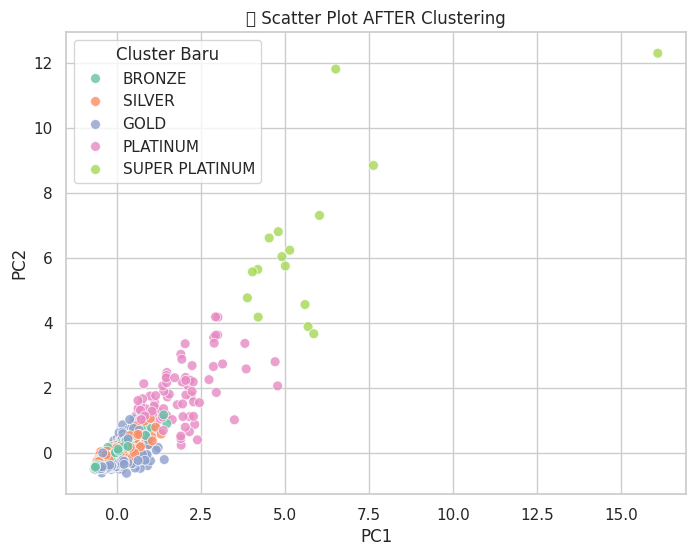

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=scaled_df,
    x=scaled_df.columns[0],
    y=scaled_df.columns[1],
    hue='Cluster_Baru',
    palette='Set2',
    s=50,
    alpha=0.8
)
plt.title('✅ Scatter Plot AFTER Clustering')
plt.xlabel(scaled_df.columns[0])
plt.ylabel(scaled_df.columns[1])
plt.legend(title='Cluster Baru')
plt.grid(True)
plt.show()

In [ ]:
tier_order = ['BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'SUPER PLATINUM']
agg_encoded['Tier_Label'] = pd.Categorical(agg_encoded['Tier_Label'],
                                           categories=tier_order,
                                           ordered=True)

In [ ]:
cross_tab = pd.crosstab(
    agg_encoded['Cluster'],
    agg_encoded['Tier_Label'],
    normalize='index'
) * 100

In [ ]:
print("\n📊 Pergeseran Cluster Lama ke Tier Baru (%):")
print(cross_tab)


📊 Pergeseran Cluster Lama ke Tier Baru (%):
Tier_Label         BRONZE     SILVER       GOLD   PLATINUM  SUPER PLATINUM
Cluster                                                                   
Bronze          12.280702   1.169591  70.760234  13.450292        2.339181
Gold            30.985915  48.063380  16.725352   3.345070        0.880282
Platinum        40.909091  29.545455  26.515152   1.515152        1.515152
Silver          45.045045   0.000000  46.396396   7.657658        0.900901
Super Platinum  22.839506  22.222222  37.654321  15.432099        1.851852


In [ ]:
# Buat crosstab
cross_tab = pd.crosstab(
    agg_encoded['Cluster'],
    agg_encoded['Tier_Label'],
    normalize='index'
) * 100

print("\n📊 Pergeseran Cluster Lama ke Tier Baru (%):")
print(cross_tab)



📊 Pergeseran Cluster Lama ke Tier Baru (%):
Tier_Label         BRONZE     SILVER       GOLD   PLATINUM  SUPER PLATINUM
Cluster                                                                   
Bronze          12.280702   1.169591  70.760234  13.450292        2.339181
Gold            30.985915  48.063380  16.725352   3.345070        0.880282
Platinum        40.909091  29.545455  26.515152   1.515152        1.515152
Silver          45.045045   0.000000  46.396396   7.657658        0.900901
Super Platinum  22.839506  22.222222  37.654321  15.432099        1.851852


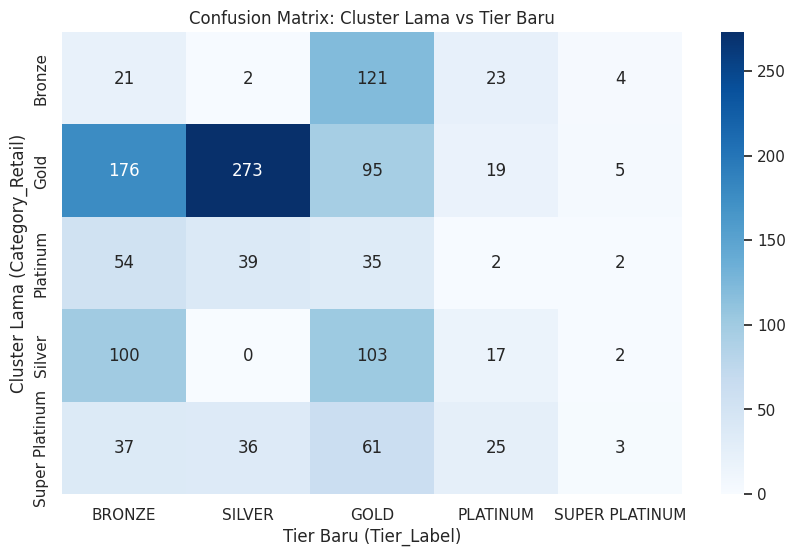

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix absolute count
count_matrix = pd.crosstab(
    agg_encoded['Cluster'],
    agg_encoded['Tier_Label']
)

plt.figure(figsize=(10, 6))
sns.heatmap(count_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Cluster Lama vs Tier Baru')
plt.ylabel('Cluster Lama (Category_Retail)')
plt.xlabel('Tier Baru (Tier_Label)')
plt.show()


In [ ]:
output_file = 'Clustering_Per_Toko_K5.csv'
agg_encoded.to_csv(output_file, index=False)
print(f"\n✅ File hasil clustering per toko disimpan: {output_file}")

files.download(output_file)